# Espesor Optico de Aerosol

In [1]:
# Imprtar los módulos necesarios

import datetime
from datetime import date
from pathlib import Path
import warnings
import s3fs
from s3fs import S3FileSystem
import os
import xarray as xr
import numpy as np
import requests
import pandas as pd
from netCDF4 import Dataset
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
import cartopy.io.img_tiles as cimgt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from PIL import Image

In [2]:

fs = s3fs.S3FileSystem(anon=True)

In [3]:
# Creamos la carpetas de trabajo

folder_path = 'C:/Users/VICTUS/OneDrive/LinkedIn/30DayChallenge/Day6/Datos'
os.makedirs(folder_path, exist_ok=True)

# Imprmimimos la ruta
print(f"Folder {folder_path} created!")

Folder C:/Users/VICTUS/OneDrive/LinkedIn/30DayChallenge/Day6/Datos created!


In [11]:
# Defina la URL del archivo en línea STAR y el nombre del archivo que desea descargar

url = 'https://www.star.nesdis.noaa.gov/pub/smcd/VIIRS_Aerosol/viirs_aerosol_gridded_data/noaa20/aod/eps/2024/'
file_name = 'viirs_eps_noaa20_aod_0.100_deg_20240903_nrt.nc'

In [12]:
# Establecemos el método de la descarga
response = requests.get(url + file_name, stream=True)

# Convertir el nombre de archivo en un objeto Path
file_path = os.path.join(folder_path, file_name)

In [13]:
# Realizamos la descarga en el directorio establecido
if response.status_code == 200:
    with open(file_path, 'wb') as file:
        for chunk in response.iter_content(1024):
            file.write(chunk)
    print(f"File {file_name} downloaded successfully!")
else:
    print(f"Failed to download file {file_name}. Status code: {response.status_code}")

File viirs_eps_noaa20_aod_0.100_deg_20240903_nrt.nc downloaded successfully!


In [18]:
# Importamos el archivo y visualizamos las características
Doc_path = "C:/Users/VICTUS/OneDrive/LinkedIn/30DayChallenge/Day6/Datos/viirs_eps_noaa20_aod_0.100_deg_20240903_nrt.nc" 
xr_file = xr.open_dataset(Doc_path, engine='netcdf4')
xr_file

<xarray.Dataset> Size: 156MB
Dimensions:       (lon: 3600, lat: 1800)
Coordinates:
  * lon           (lon) float32 14kB -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * lat           (lat) float32 7kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
Data variables:
    AOD550        (lat, lon) float32 26MB ...
    AE            (lat, lon) float32 26MB ...
    AOD550_count  (lat, lon) uint16 13MB ...
    AE_count      (lat, lon) uint16 13MB ...
    AOD550max     (lat, lon) float32 26MB ...
    AOD550min     (lat, lon) float32 26MB ...
    AOD550std     (lat, lon) float32 26MB ...
Attributes:
    dataset_name:        viirs_eps_noaa20_aod_0.100_deg_20240903_nrt.nc
    title:               NOAA Enterprise L3 Aerosol Optical Depth
    spatial_resolution:   0.10 degree
    processing_level:    National Oceanic and Atmospheric Administration (NOA...
    Conventions:         CF-1.6
    instrument_name:     VIIRS
    satellite_name:      NOAA 20
    source:              VIIRS EPS high quality AOD

In [61]:
# Enlaces a los mapas topográficos mundiales de ESRI

tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}.jpg'
tiles_attribution = 'Source: Map tiles by Esri / Data: NOAA20-VIIRS AOD550nm 0.1 deg / Python: @Jorge A. Zampieri'

# Recupera el azulejo especificado por la URL "azulejos

map_tiles_image = cimgt.GoogleTiles(url=tiles)

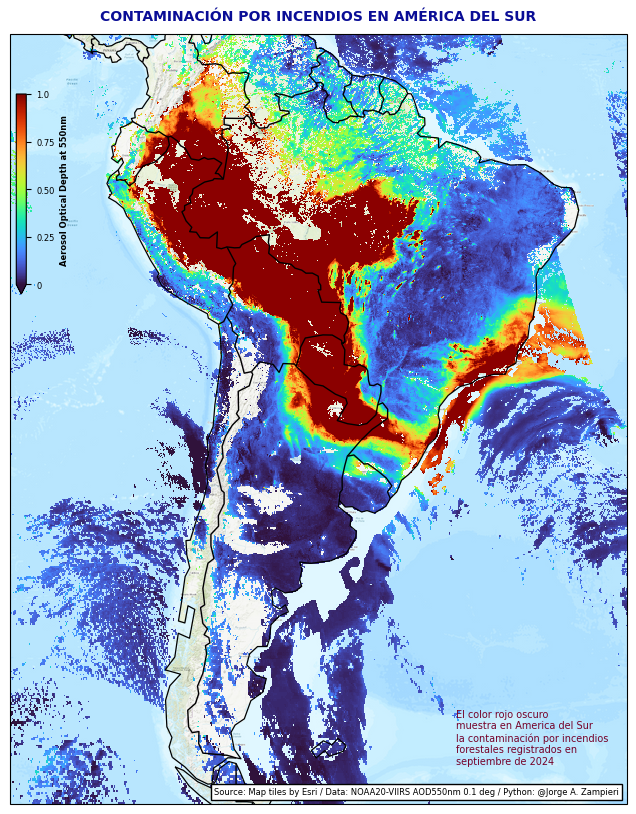

In [73]:
# Configurando la figura, se añade ejes y se establece la proyección del mapa para que sea la misma que la de los mosaicos del mapa.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=map_tiles_image.crs)

# Obtención de mapas y atribución

zoom_level = 6  # Zoom-in level for map tiles
ax.add_image(map_tiles_image, zoom_level, interpolation='spline36')
anchored_text = AnchoredText(tiles_attribution, loc='lower right', prop=dict(size=6))
ax.add_artist(anchored_text)

# Set map geographic domain [W_lon, E_lon, S_lat, N_lat]
# °E longitude > 0 > °W longitude, °N latitude > 0 > °S latitude
ax.set_extent([-91, -30, -55, 10], crs=ccrs.PlateCarree())

# Añade líneas de costa y bordes, sombrea polígonos de tierra y agua
# El argumento "zorder" establece el orden de trazado de las capas (zorder mayor traza sobre zorder menor)

ax.add_feature(cfeature.COASTLINE, linewidth=0.9, zorder=2)
ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=2)


# Establecer mapa de colores con color único para datos > vmax
cmap = plt.get_cmap('turbo').with_extremes(over='darkred')

# Plot AOD550 data
# El argumento "transform=ccrs.PlateCarree()" indica a cartopy que los datos están en coordenadas geográficas (lat/lon)

plot = ax.pcolormesh(xr_file.lon, xr_file.lat, xr_file.AOD550, cmap=cmap, vmin=0, vmax=1,
                     transform=ccrs.PlateCarree())

# Añadir barra de color
cb = fig.colorbar(plot, orientation='vertical', fraction=0.05, pad=0.04, 
                  shrink=0.6, ticks=[0, 0.25, 0.5, 0.75, 1], extend='min') 
cb.set_label(label='Aerosol Optical Depth at 550nm', size=6, weight='bold') 
cb.ax.set_yticklabels(['0', '0.25', '0.50', '0.75', '1.0'], fontsize=6) # Ajustar la posición de la barra de color 
cb.ax.set_position([0.22, 0.62, 0.1, 0.2])


# Añadir título al gráfico
plot_title = 'CONTAMINACIÓN POR INCENDIOS EN AMÉRICA DEL SUR'
plt.title(plot_title, pad=10, size=10, weight='bold', color='#0a0d96')
plt.figtext(0.66, 0.15, 'El color rojo oscuro\nmuestra en America del Sur\nla contaminación por incendios\nforestales registrados en\nseptiembre de 2024', 
            fontsize=7, ha='left', color='#760229')

fig.savefig('Day6_Raster.png', dpi=600, bbox_inches='tight')
# Mostramos el mapa
plt.show()